**Review**

Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did an excellent job! The project is accepted. Good luck on the next sprint!

> I didn't apply the BERT model.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Ok, it's not required

</div>

# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import string

from tqdm.auto import tqdm
import re
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.columns

Index(['tconst', 'title_type', 'primary_title', 'original_title', 'start_year',
       'end_year', 'runtime_minutes', 'is_adult', 'genres', 'average_rating',
       'votes', 'review', 'rating', 'sp', 'pos', 'ds_part', 'idx'],
      dtype='object')

In [6]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [7]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [8]:
df_reviews.dropna(inplace=True)

<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was loaded and inspected!

</div>

## EDA

Let's check the number of movies and reviews over years.

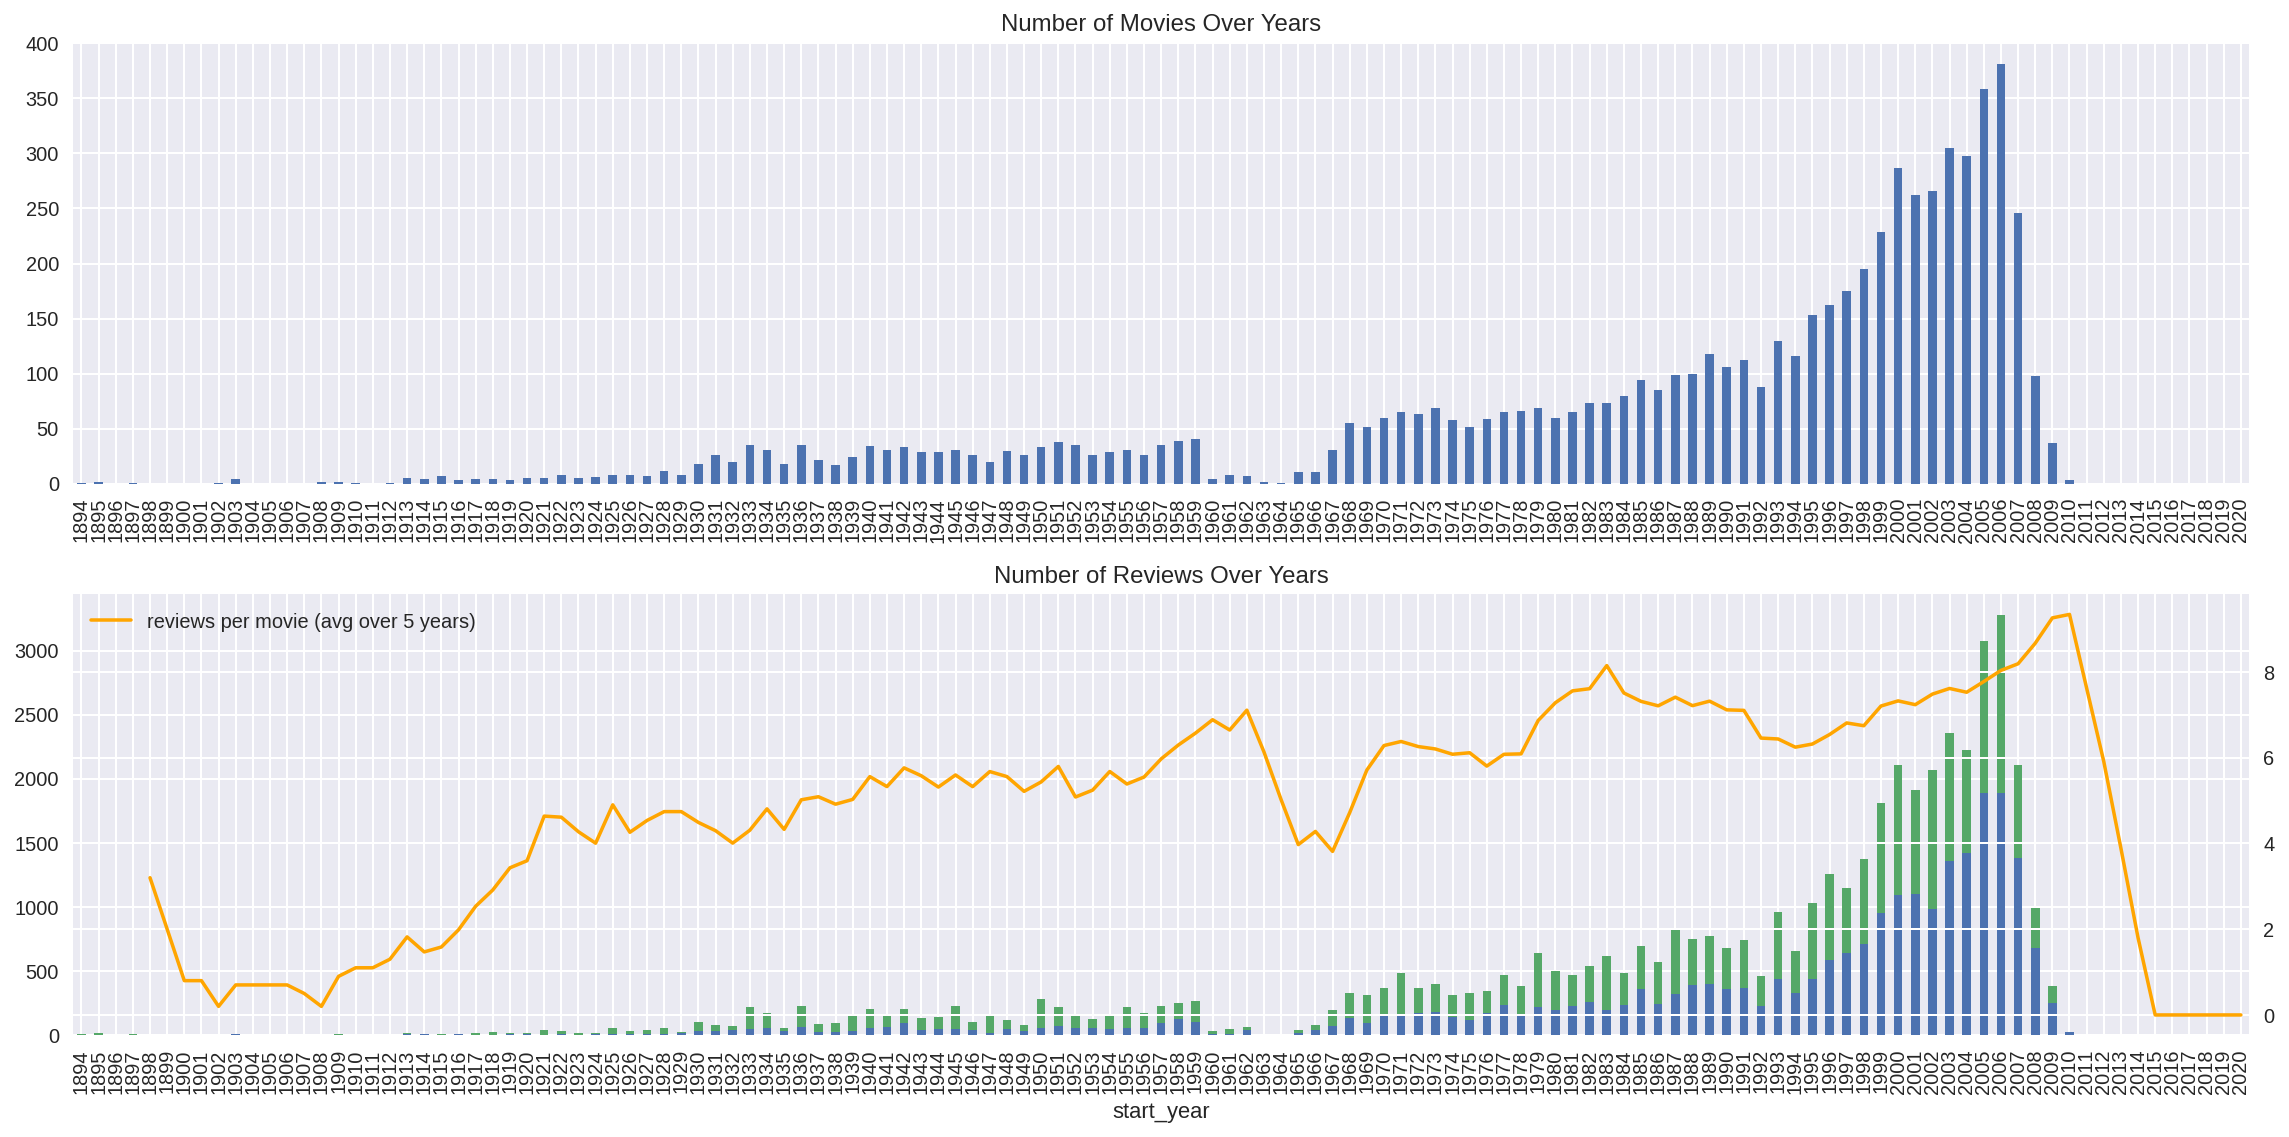

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

According to the distribution plots, we can conclude that:

* There are less than 50 movies yearly before 1968, then movies were released increasely every year until 2006 which is 381. At last the number of yearly released movie dropped to near zero in 2010.

* The number of average reviews per movie preforms hysteresis due to the calculation method of rolling. Generally it reflects the trends of number of yearly released movie which is increasing until 2006, however, the rate of increase is less steep than latter. Although there are mot many movies released before 1960, the number of reviews didn't fall behind. Another interesting point is there is a peak of average number of reviews on the year of 1894, it seems that people likes to review on the oldest movies.

* The reviews polarity seems in balance, let's discuss it later.

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

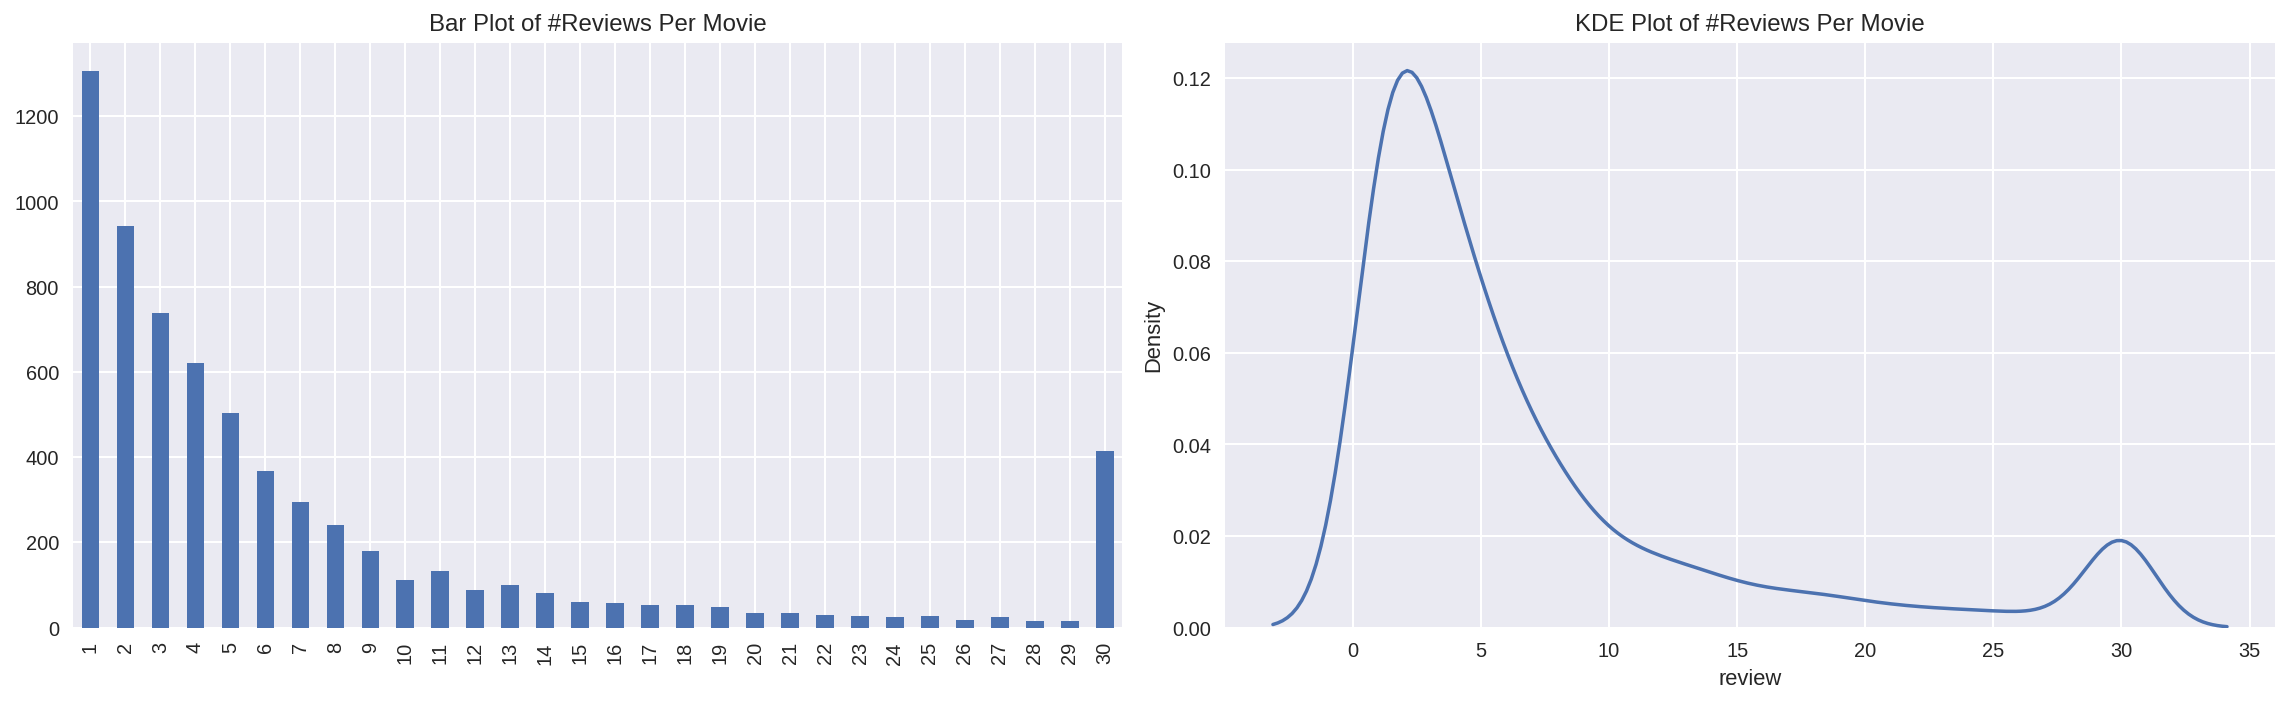

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

Most of movies have less than 5 reviews, then the number of reviews decreases gradually until 20 reviews. But there is a peak that more than 400 movies have 30 reviews.

<div class="alert alert-success">
<b>Reviewer's comment</b>

The peak is likely due to 30 being the maximum cutoff for the number of reviews for a single movie, otherwise we'd have thousands of reviews for very popular movies 

</div>

In [11]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

The numbers of positive and negative targets are nealy the same.

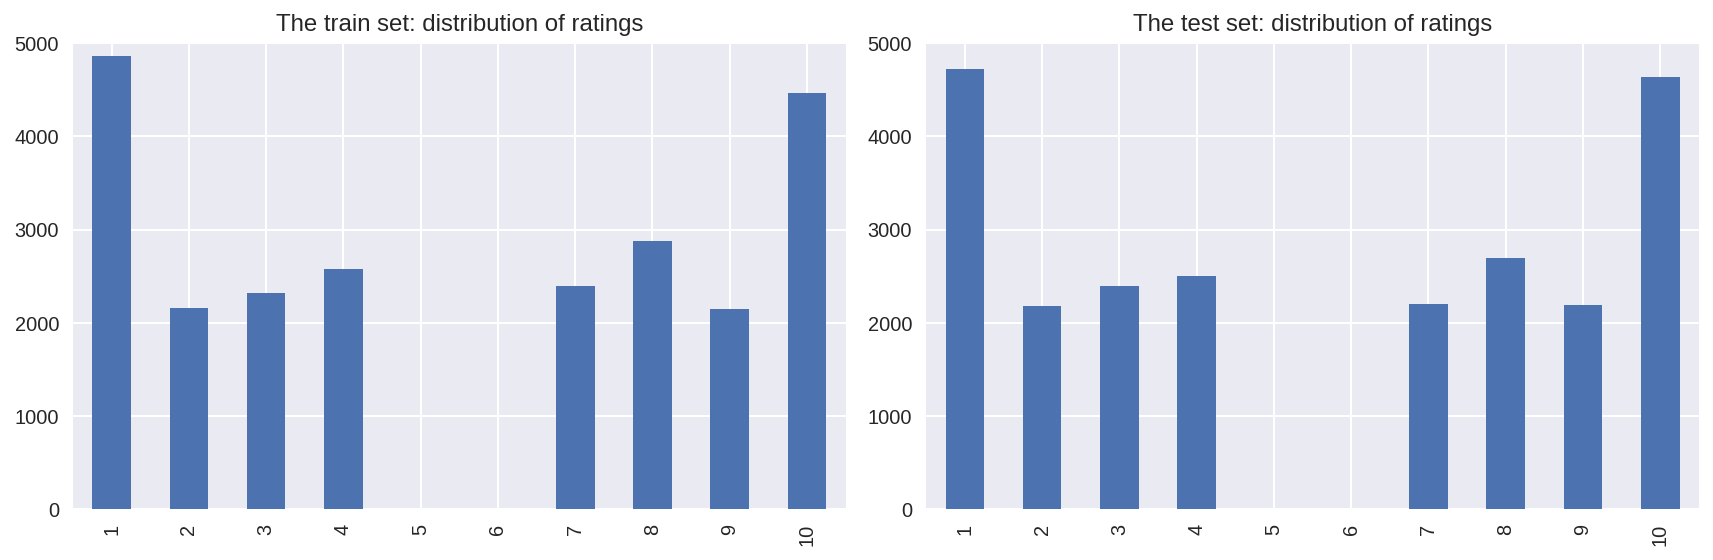

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

* The distribution of ratings from training and testing set are the same.

* The ratings shows polarization. There is no ratings in the middle score, while the scores of 1 and 10 take significant proportion

Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


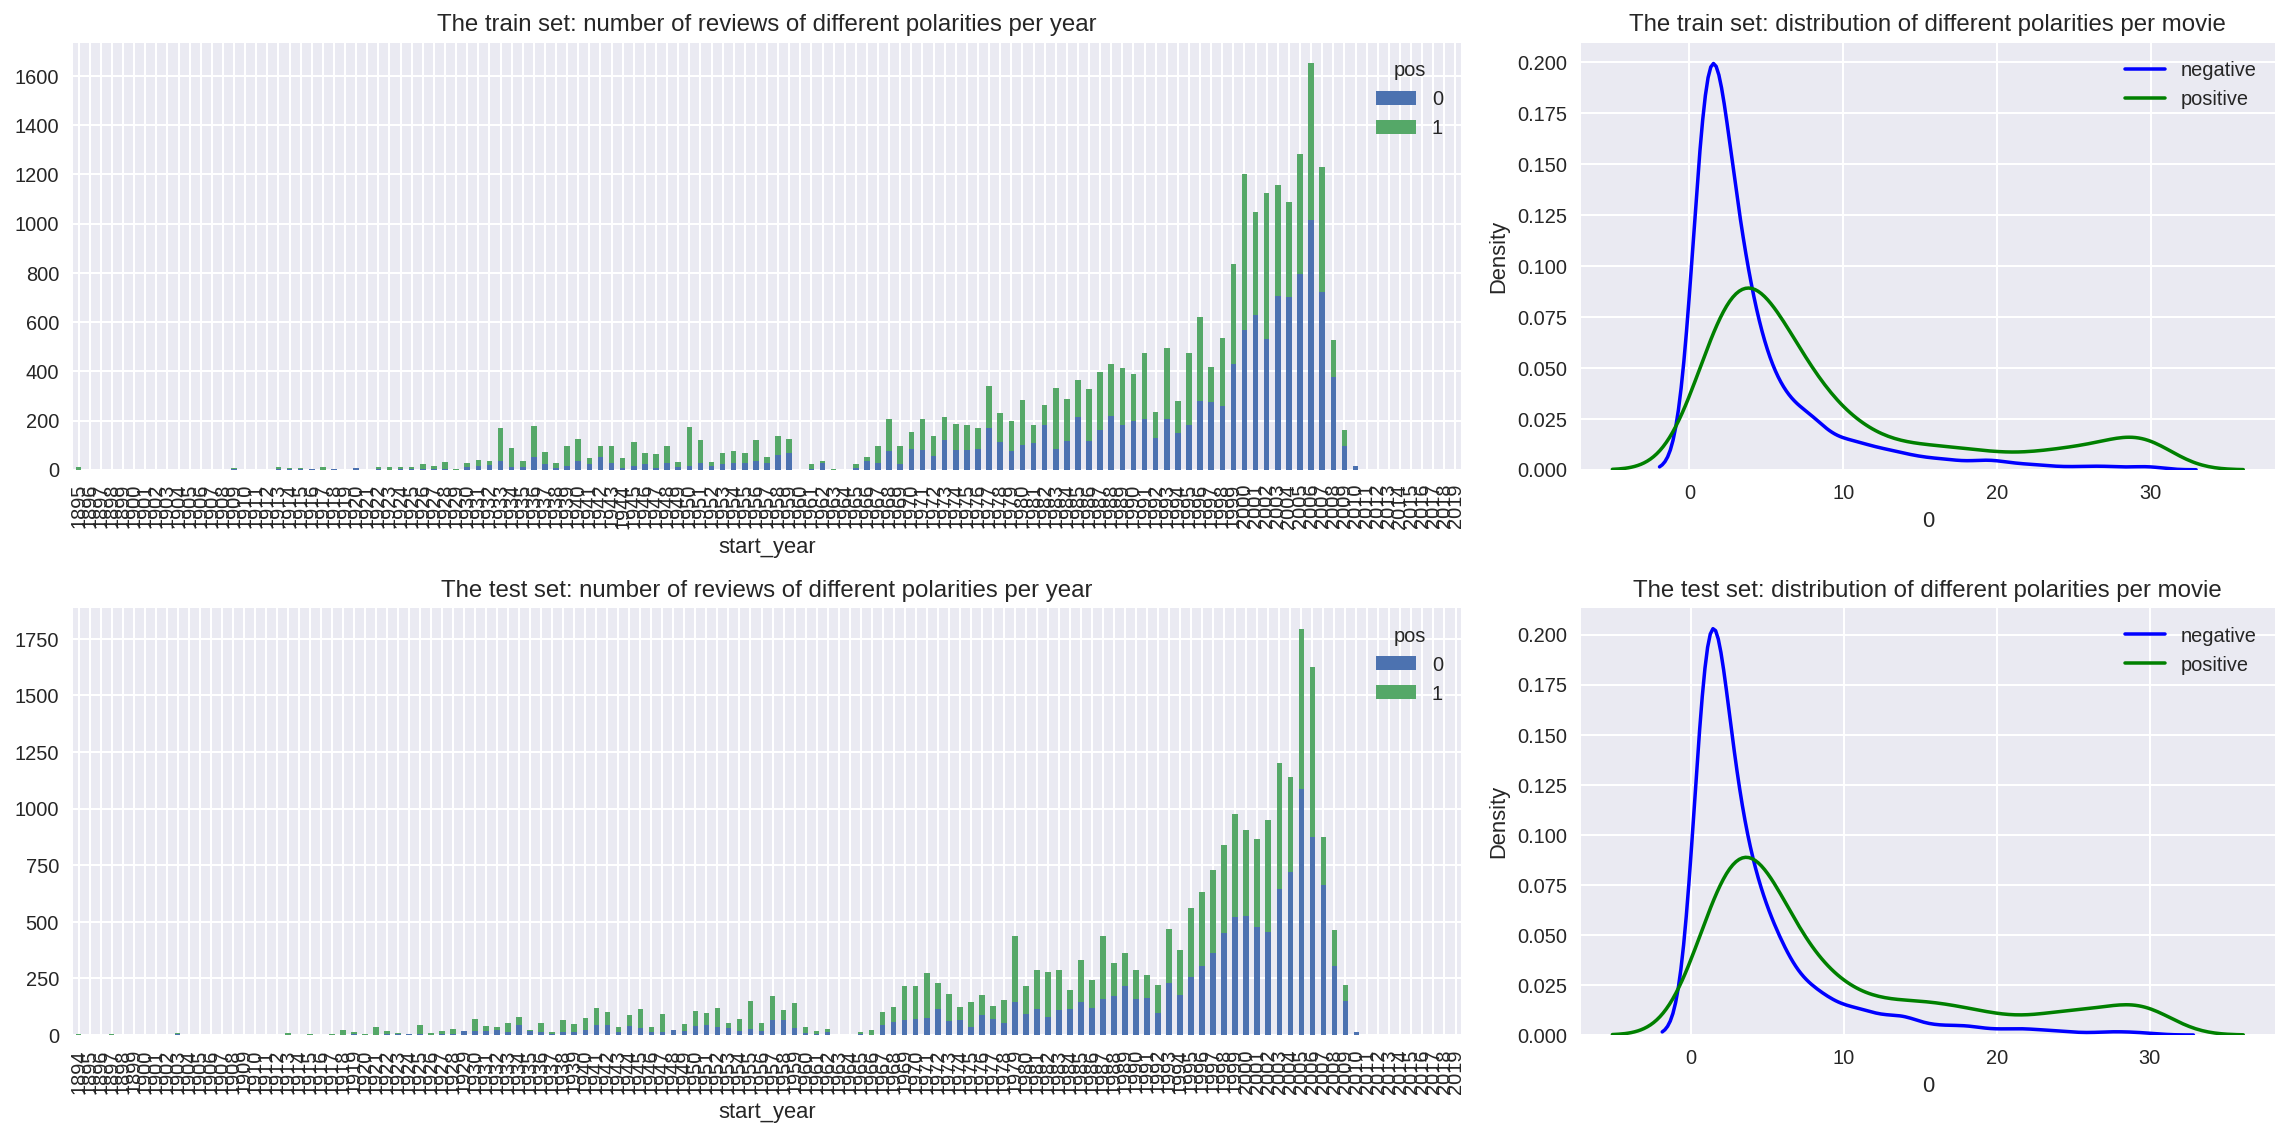

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

There is an interesting point that the Movies with fewer reviews generally have negative ratings, on the other hand, movies with more than 5 reviews have more positive comments than negative ones. Especially for movies with more than 20 reviews, there is quite few negative reviews.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Great, you explored the data and made some interesting observations!

</div>

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [14]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [15]:
def normalize_review(text):
    text = text.lower()
    text = re.sub(r'[{}]'.format(string.punctuation + string.digits), ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

In [16]:
df_reviews['review_norm'] = df_reviews['review'].apply(normalize_review)

<div class="alert alert-success">
<b>Reviewer's comment</b>

Normalization looks good!

</div>

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

### One-hot encoding

#### Seperate 'genres'

In [17]:
encoded_df = df_reviews.copy()
encoded_df.reset_index(drop=True, inplace=True)
genre_dummies = encoded_df['genres'].str.get_dummies(',')
encoded_df = pd.concat([encoded_df, genre_dummies], axis=1)

#### Encoding other categorical features

In [18]:
categorical = ['tconst', 'title_type', 'is_adult']
encoded_df = pd.get_dummies(encoded_df, columns=categorical, drop_first=True)

### Feature selection

In [19]:
drop_list = ['primary_title', 'original_title', 'end_year', 'average_rating', 'sp', 'idx', 'review', 'genres','\\N']
encoded_df.drop(drop_list, axis=1, inplace=True)

### Split data

In [20]:
df_reviews_train = encoded_df.query('ds_part == "train"').copy()
df_reviews_test = encoded_df.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']
train_features = df_reviews_train.drop(['pos', 'ds_part'], axis=1)
test_features = df_reviews_test.drop(['pos', 'ds_part'], axis=1)

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 6691)
(23533, 6691)


In [21]:
train_features.sample(5)

,start_year,runtime_minutes,votes,rating,review_norm,Action,Adult,Adventure,Animation,Biography,...,title_type_short,title_type_tvEpisode,title_type_tvMiniSeries,title_type_tvMovie,title_type_tvSeries,title_type_tvShort,title_type_tvSpecial,title_type_video,title_type_videoGame,is_adult_1
36338,1984,92,1725,10,what can i say about this movie i have seen it...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33623,1981,115,5073,1,i wanted to vote zero or lower i loved the com...,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
35016,1933,92,422,8,four words account for why this film was made ...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23444,1989,103,65545,9,daniel day lewis is christy brown a victim of ...,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
44295,1999,102,3188,3,this movie is despite its independent status a...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<div class="alert alert-warning">
<b>Reviewer's comment</b>

I guess you intended to use these features, but then turned to just review texts. Some of the features do sound promising, but you'd probably have to do something to cut down the number of columns (e.g. use a different encoding, as 6000+ columns are hard to work with)

</div>

## Working with models

### Model 0 - Constant

In [22]:
from sklearn.dummy import DummyClassifier

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


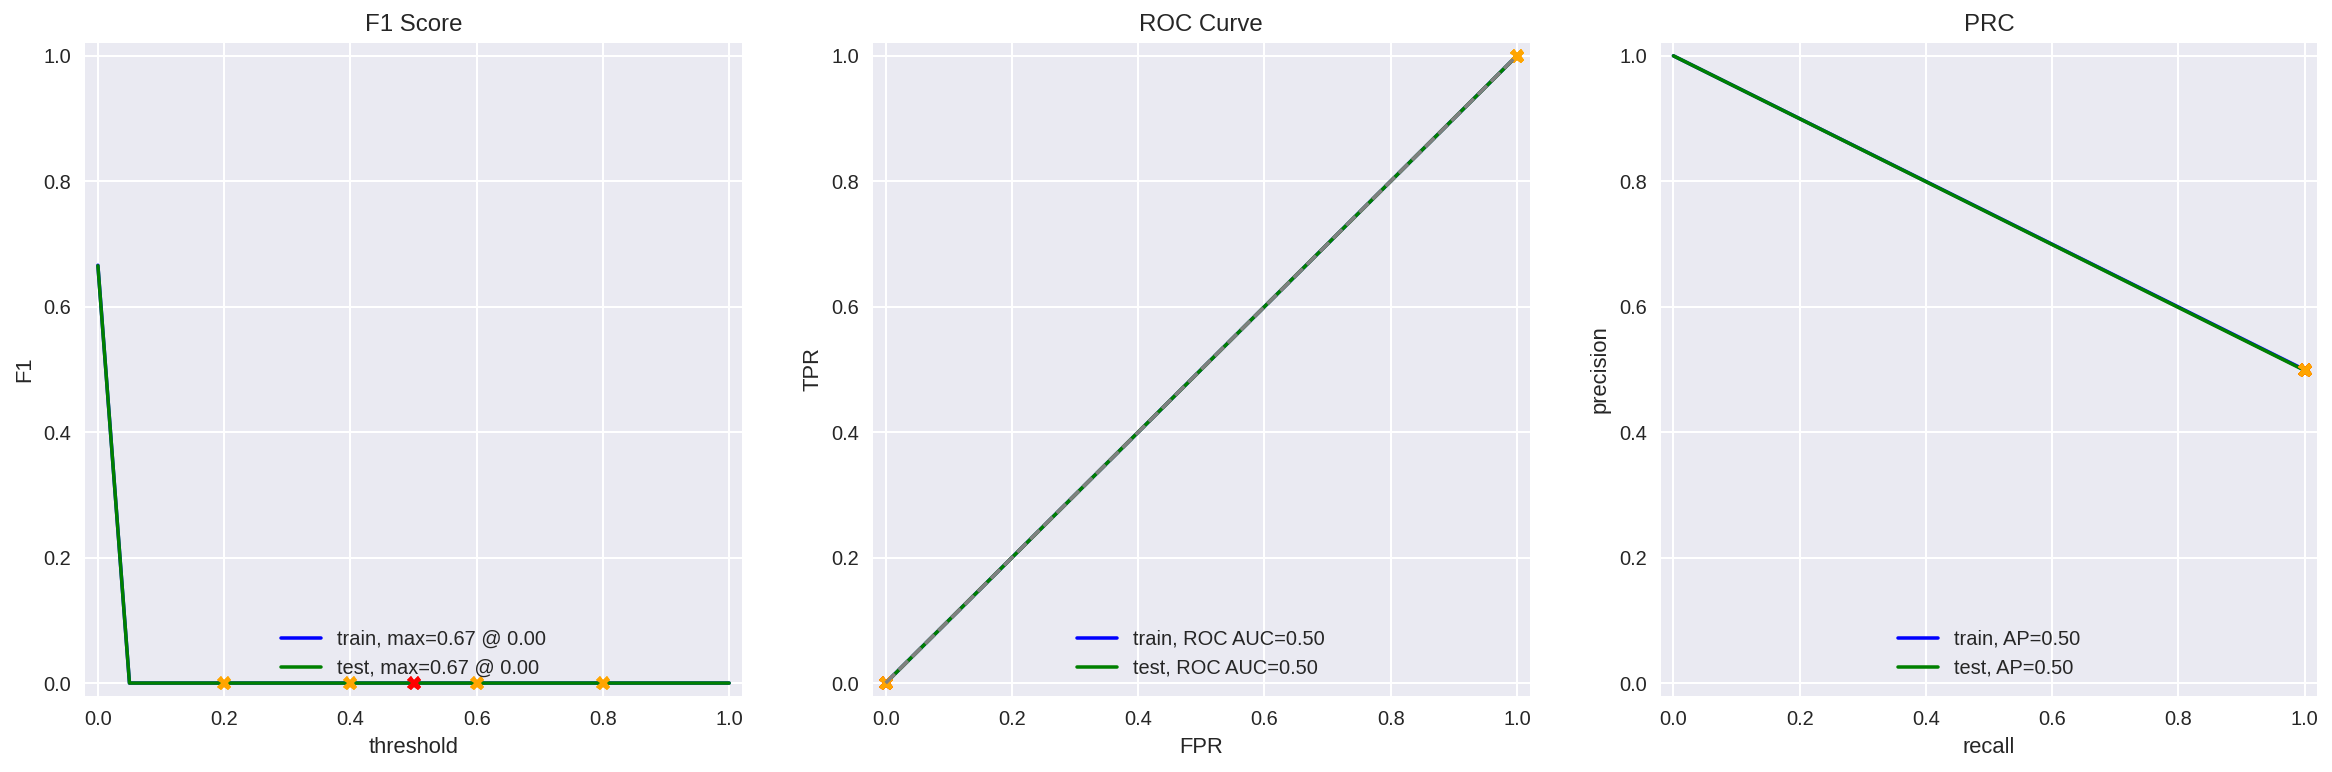

In [23]:
model_0 = DummyClassifier(strategy="most_frequent")
model_0.fit(train_features, train_target)
evaluate_model(model_0, train_features, train_target, test_features, test_target)

<div class="alert alert-success">
<b>Reviewer's comment</b>

Ok, here's a very simple baseline

</div>

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [47]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from nltk.corpus import stopwords

In [26]:
stop_words = set(stopwords.words('english'))
count_tf_idf_1 = TfidfVectorizer(stop_words=stop_words)

train_corpus_1 = train_features['review_norm']
train_features_1 = count_tf_idf_1.fit_transform(train_corpus_1)
test_corpus_1 = test_features['review_norm']
test_features_1 = count_tf_idf_1.transform(test_corpus_1)

model_1 = LogisticRegression()
model_1.fit(train_features_1, train_target)

LogisticRegression()

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


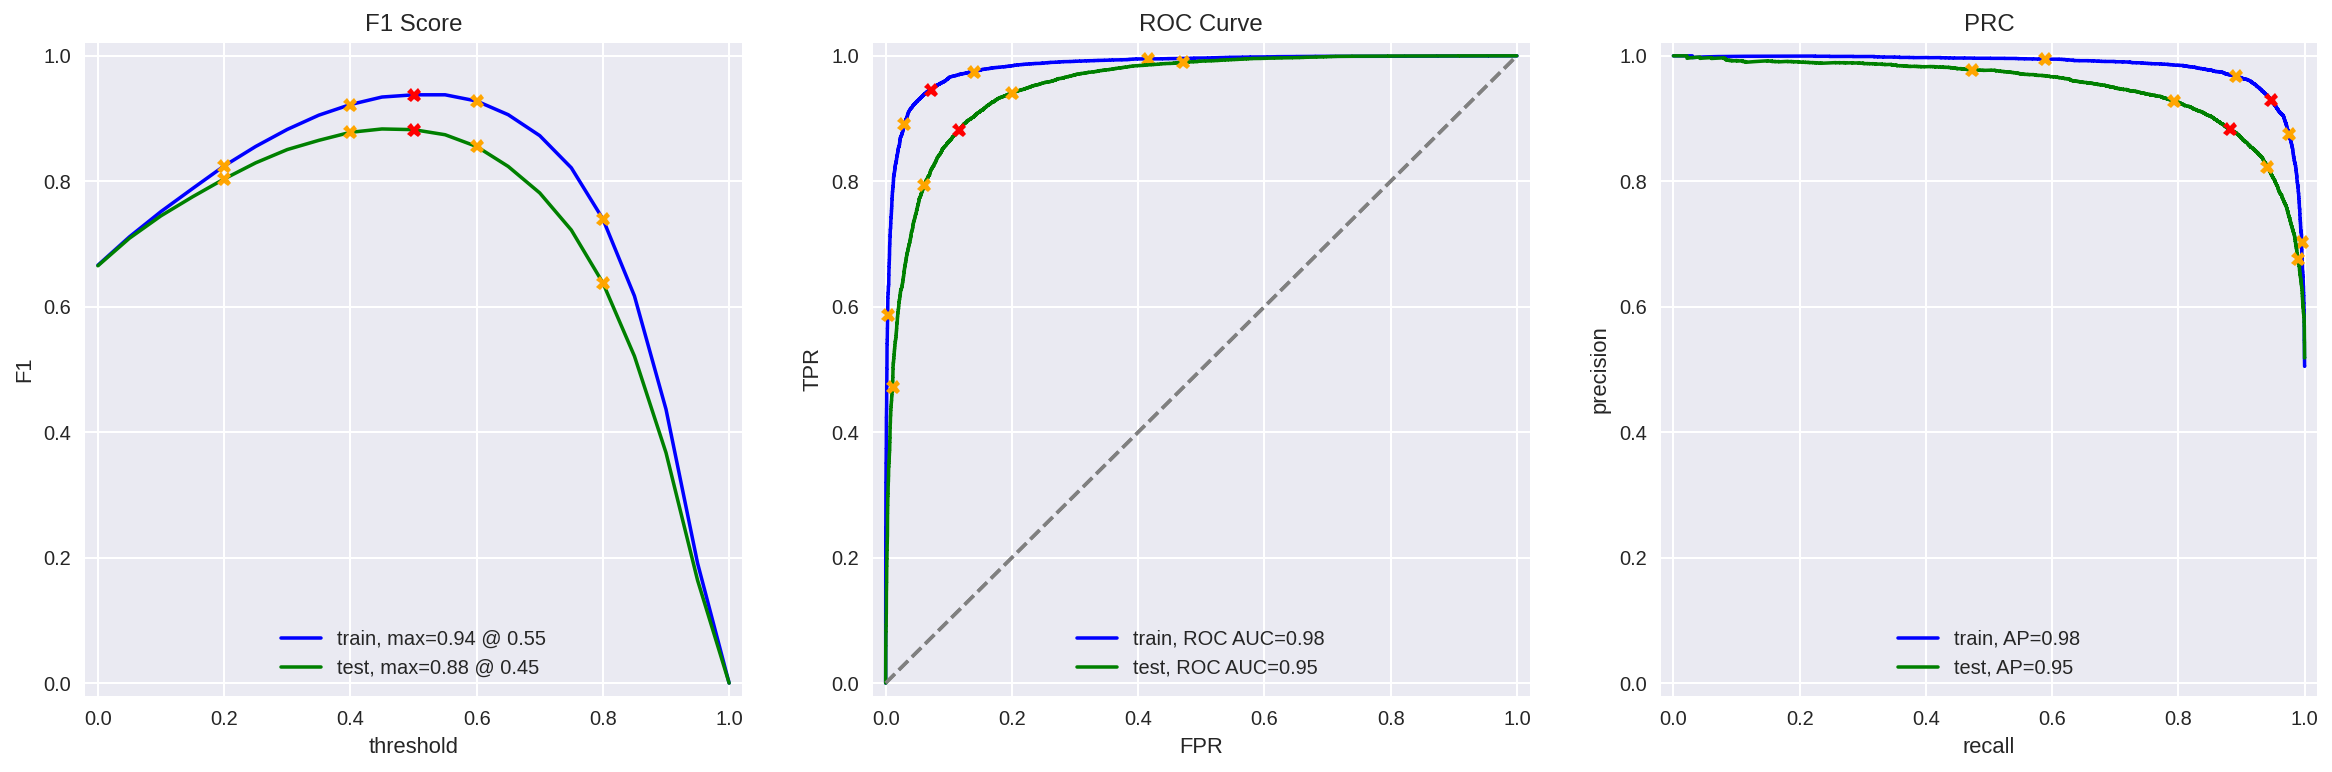

In [27]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Model 2 - NLTK, TF-IDF and XGBoost

/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:05:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
          train  test
Accuracy   0.95  0.85
F1         0.95  0.85
APS        0.99  0.93
ROC AUC    0.99  0.93


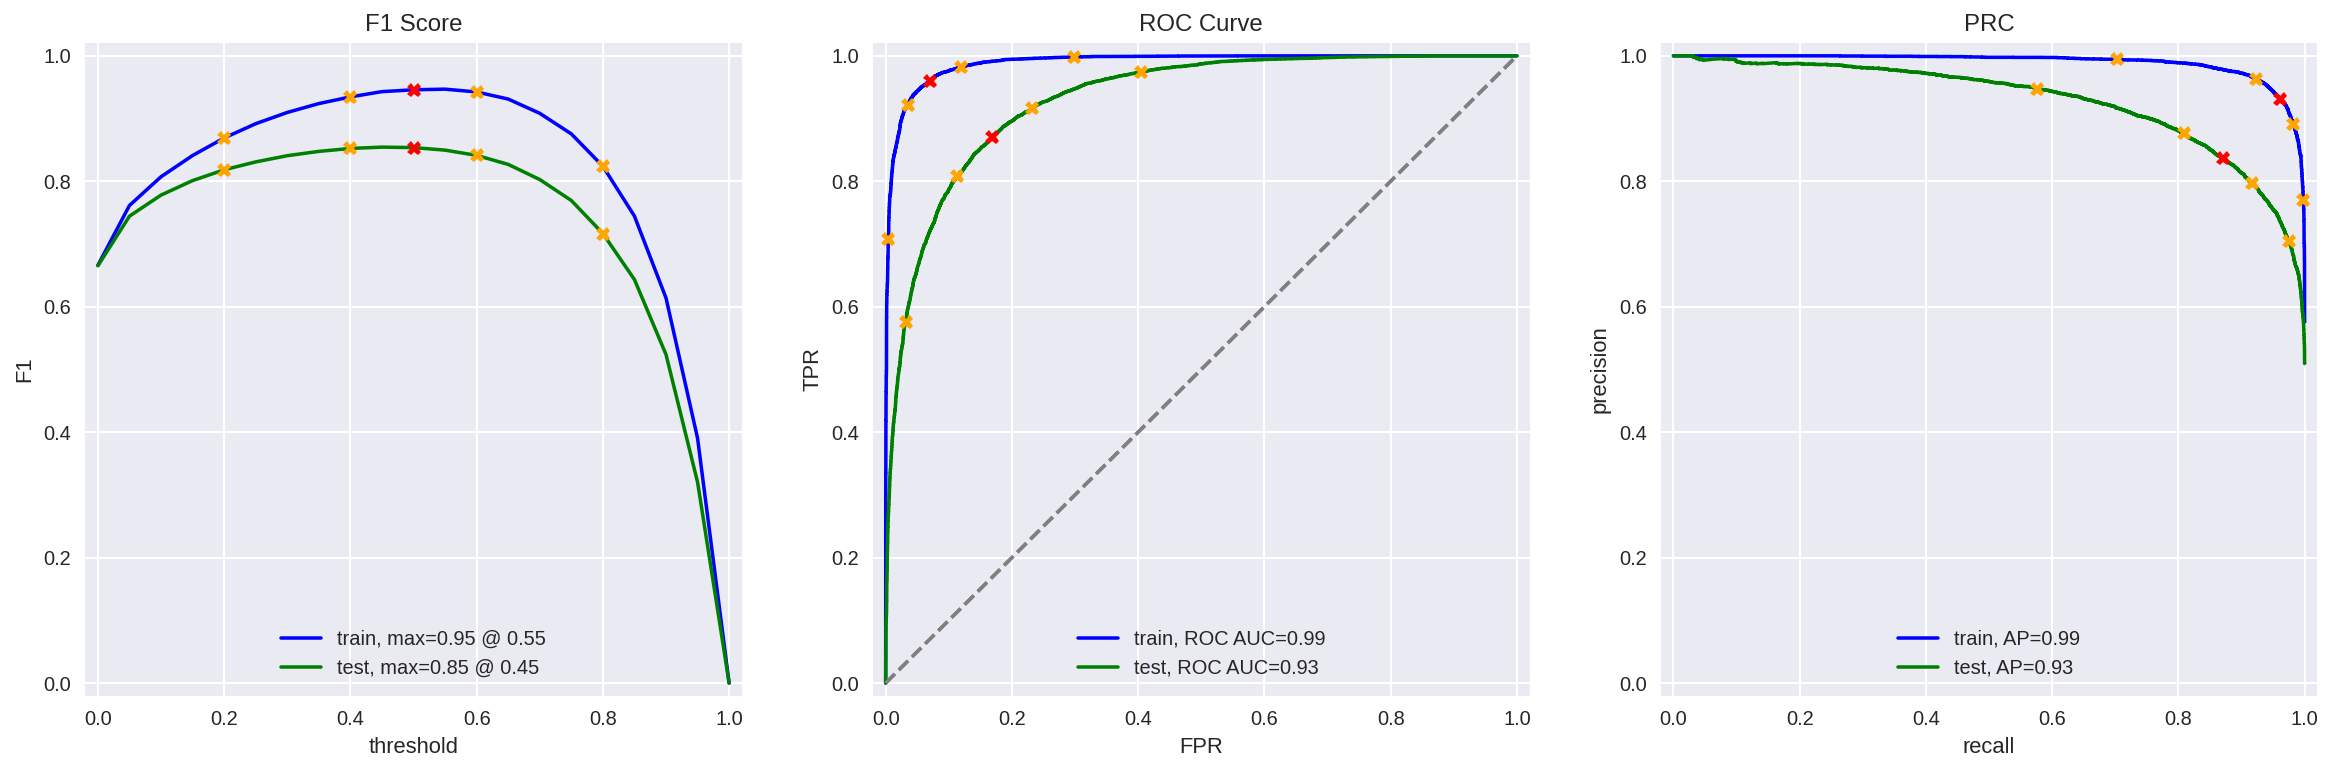

In [51]:
model_2 = xgb.XGBClassifier()
model_2.fit(train_features_1, train_target)
evaluate_model(model_2, train_features_1, train_target, test_features_1, test_target)

### Model 3 - spaCy, TF-IDF and LR

In [28]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [29]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

<div class="alert alert-success">
<b>Reviewer's comment</b>

It's nice that you tried lemmatization!

</div>

In [31]:
train_features['review_norm'] = train_features['review_norm'].apply(text_preprocessing_3)
test_features['review_norm'] = test_features['review_norm'].apply(text_preprocessing_3)

count_tf_idf_3 = TfidfVectorizer(stop_words=stop_words)
train_corpus_3 = train_features['review_norm']
train_features_3 = count_tf_idf_3.fit_transform(train_corpus_3)
test_corpus_3 = test_features['review_norm']
test_features_3 = count_tf_idf_3.transform(test_corpus_3)

model_3 = LogisticRegression()
model_3.fit(train_features_3, train_target)

LogisticRegression()

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


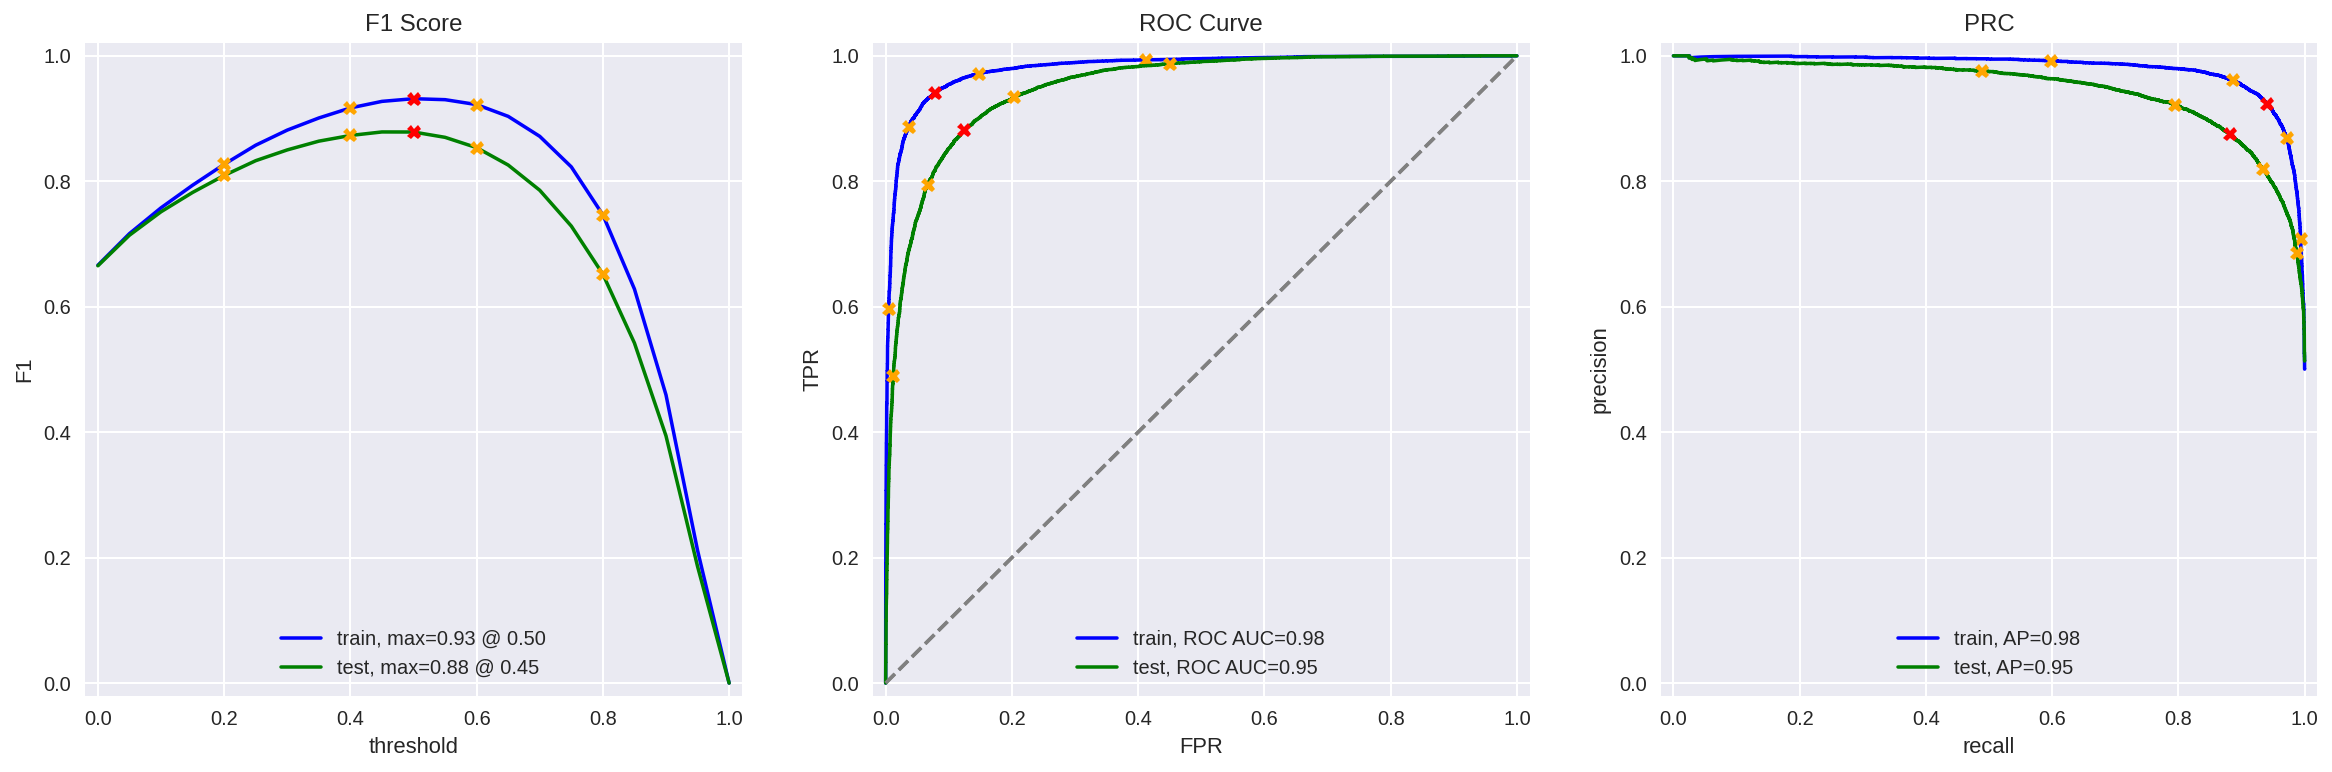

In [32]:
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [33]:
from lightgbm import LGBMClassifier

In [43]:
model_4 = LGBMClassifier()
model_4.fit(train_features_3, train_target)

LGBMClassifier()

          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


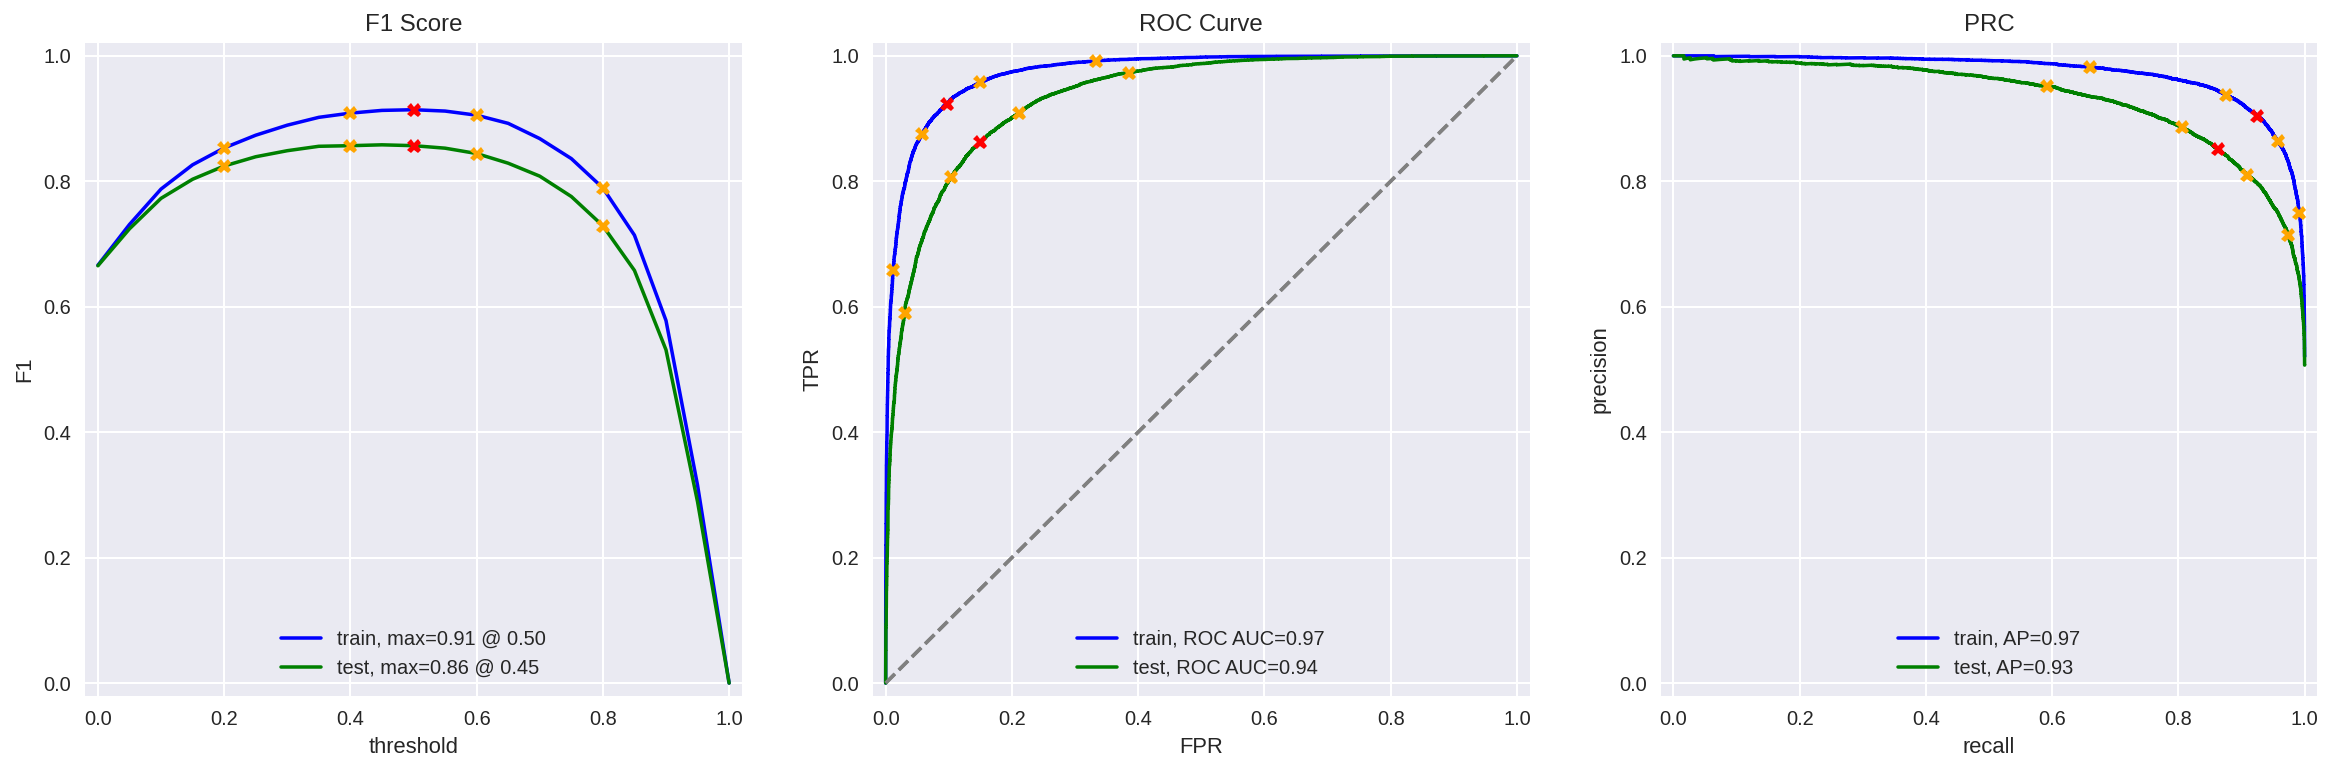

In [44]:
evaluate_model(model_4, train_features_3, train_target, test_features_3, test_target)

### Model 5 - spaCy, TF-IDF and XGBClassifier

/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:11:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
          train  test
Accuracy   0.95  0.85
F1         0.95  0.85
APS        0.99  0.93
ROC AUC    0.99  0.93


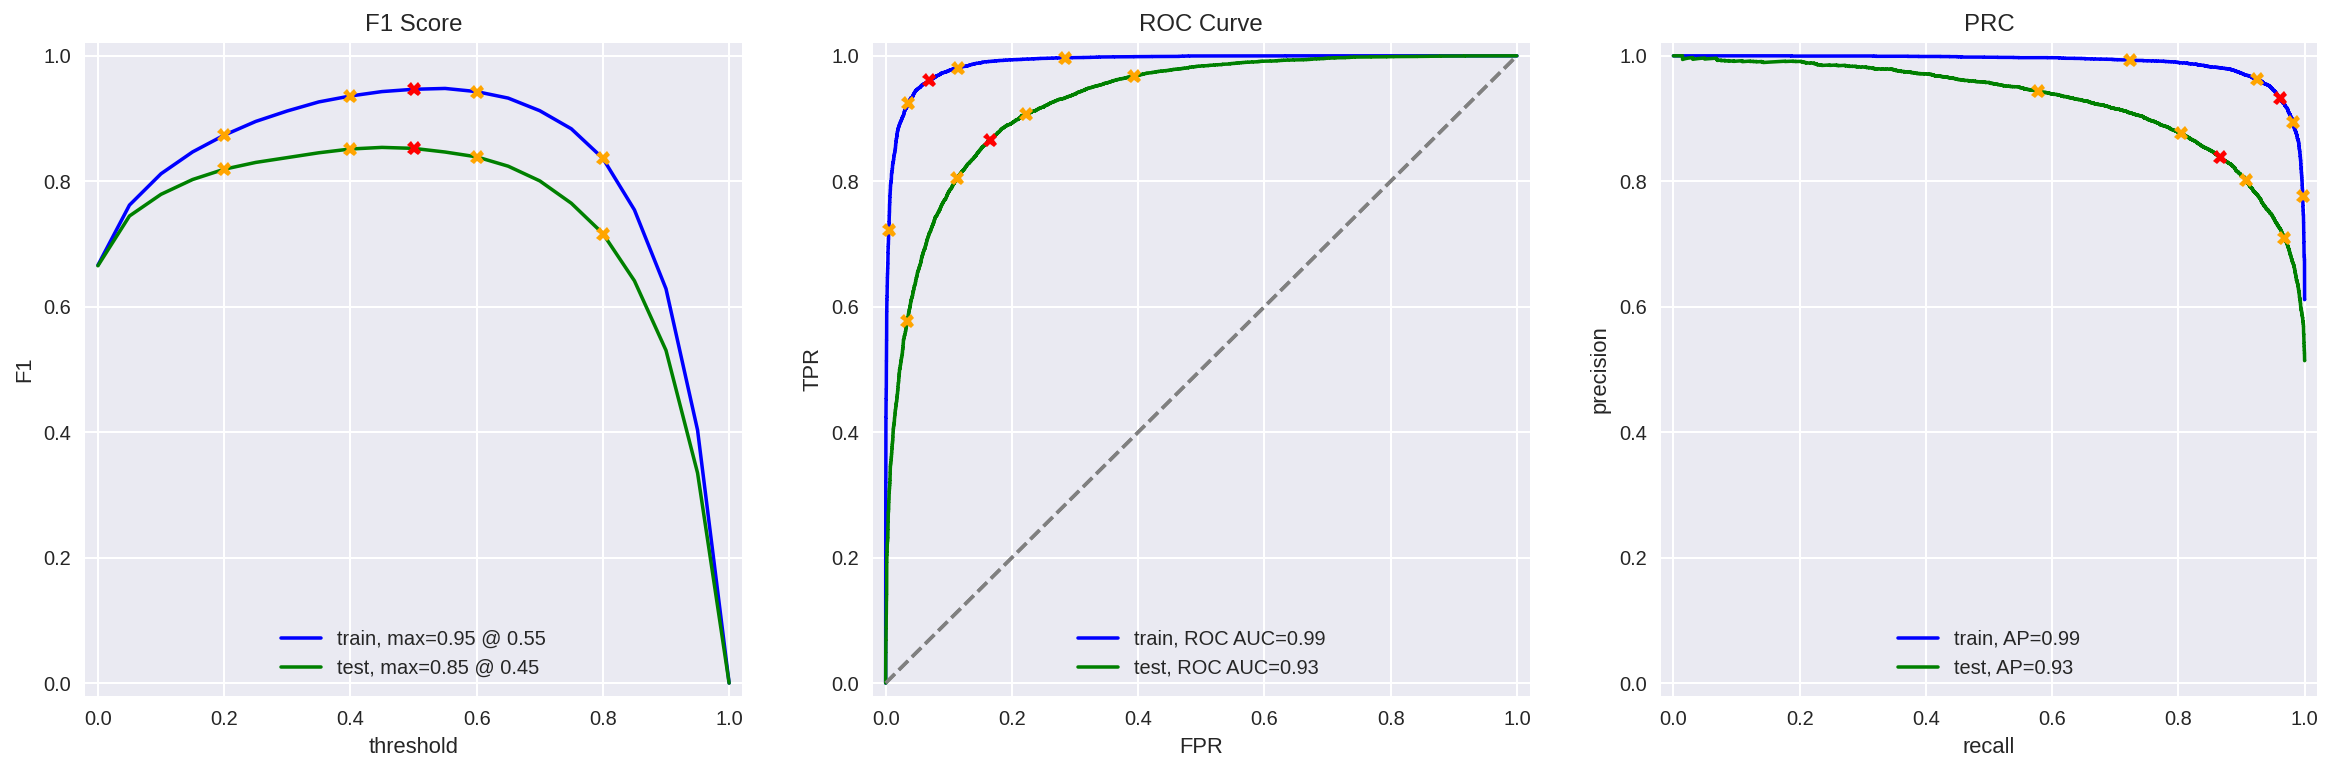

In [54]:
model_5 = xgb.XGBClassifier()
model_5.fit(train_features_3, train_target)
evaluate_model(model_5, train_features_3, train_target, test_features_3, test_target)

<div class="alert alert-success">
<b>Reviewer's comment</b>

Great, you successfully vectorized text data using TF-IDF and trained a couple of different models using the resulting features

</div>

###  Model 9 - BERT

In [ ]:
import torch
import transformers

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [ ]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    
    # <put your code here to create ids_list and attention_mask_list>
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <put your code here to create attention_mask_batch
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [ ]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
#train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [ ]:
# print(df_reviews_train['review_norm'].shape)
# print(train_features_9.shape)
# print(train_target.shape)

In [ ]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## My Reviews

In [36]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])
my_reviews['ground_truth'] = [0,0,1,0,1,1,0,1]
my_reviews['review_norm'] = my_reviews['review'].apply(normalize_review)# <put here the same normalization logic as for the main dataset>

my_reviews

,review,ground_truth,review_norm
0,"I did not simply like it, not my kind of movie.",0,i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",0,well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,1,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,0,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,1,i didn t expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",1,the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,0,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,1,launching on netflix was a brave move i really...


### Model 1

In [37]:
train_corpus_1.shape

(23796,)

In [38]:
texts = my_reviews['review_norm']
#count_tf_idf_1.fit(train_corpus_1)
my_reviews_pred_prob = model_1.predict_proba(count_tf_idf_1.transform(texts))[:, 1]

pred = []
for i, review in enumerate(texts.str.slice(0, 100)):
    if my_reviews_pred_prob[i] < 0.5:
        pred.append(0)
    else:
        pred.append(1)
    print(f"{my_reviews['ground_truth'][i]} -- {my_reviews_pred_prob[i]:.2f}:  {review}")
print("The f1 score of my reviews dataset is ", f1_score(my_reviews['ground_truth'], pred))

0 -- 0.14:  i did not simply like it not my kind of movie 
0 -- 0.16:  well i was bored and felt asleep in the middle of the movie 
1 -- 0.54:  i was really fascinated with the movie
0 -- 0.11:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
1 -- 0.31:  i didn t expect the reboot to be so good writers really cared about the source material
1 -- 0.47:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0 -- 0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
1 -- 0.82:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo
The f1 score of my reviews dataset is  0.6666666666666666


### Model 2

In [55]:
my_reviews_pred_prob = model_2.predict_proba(count_tf_idf_1.transform(texts))[:, 1]

pred = []
for i, review in enumerate(texts.str.slice(0, 100)):
    if my_reviews_pred_prob[i] < 0.5:
        pred.append(0)
    else:
        pred.append(1)
    print(f"{my_reviews['ground_truth'][i]} -- {my_reviews_pred_prob[i]:.2f}:  {review}")
print("The f1 score of my reviews dataset is ", f1_score(my_reviews['ground_truth'], pred))

0 -- 0.60:  i did not simply like it not my kind of movie 
0 -- 0.42:  well i was bored and felt asleep in the middle of the movie 
1 -- 0.60:  i was really fascinated with the movie
0 -- 0.41:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
1 -- 0.54:  i didn t expect the reboot to be so good writers really cared about the source material
1 -- 0.59:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0 -- 0.26:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
1 -- 0.61:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo
The f1 score of my reviews dataset is  0.888888888888889


### Model 3

In [41]:
texts = my_reviews['review_norm']
count_tf_idf_3.fit(train_corpus_3)
my_reviews_pred_prob = model_3.predict_proba(count_tf_idf_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]
pred = []
for i, review in enumerate(texts.str.slice(0, 100)):
    if my_reviews_pred_prob[i] < 0.5:
        pred.append(0)
    else:
        pred.append(1)
    print(f"{my_reviews['ground_truth'][i]} -- {my_reviews_pred_prob[i]:.2f}:  {review}")
print("The f1 score of my reviews dataset is ", f1_score(my_reviews['ground_truth'], pred))

0 -- 0.20:  i did not simply like it not my kind of movie 
0 -- 0.12:  well i was bored and felt asleep in the middle of the movie 
1 -- 0.48:  i was really fascinated with the movie
0 -- 0.09:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
1 -- 0.26:  i didn t expect the reboot to be so good writers really cared about the source material
1 -- 0.51:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0 -- 0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
1 -- 0.92:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo
The f1 score of my reviews dataset is  0.6666666666666666


### Model 4

In [42]:
texts = my_reviews['review_norm']
pred = []
#tfidf_vectorizer_4 = tfidf_vectorizer_3
#my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]
my_reviews_pred_prob = model_4.predict_proba(count_tf_idf_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]
for i, review in enumerate(texts.str.slice(0, 100)):
    if my_reviews_pred_prob[i] < 0.5:
        pred.append(0)
    else:
        pred.append(1)
    print(f"{my_reviews['ground_truth'][i]} -- {my_reviews_pred_prob[i]:.2f}:  {review}")
print("The f1 score of my reviews dataset is ", f1_score(my_reviews['ground_truth'], pred))

0 -- 0.54:  i did not simply like it not my kind of movie 
0 -- 0.42:  well i was bored and felt asleep in the middle of the movie 
1 -- 0.60:  i was really fascinated with the movie
0 -- 0.35:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
1 -- 0.69:  i didn t expect the reboot to be so good writers really cared about the source material
1 -- 0.67:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0 -- 0.27:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
1 -- 0.78:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo
The f1 score of my reviews dataset is  0.888888888888889


### Model 5

In [56]:
texts = my_reviews['review_norm']
count_tf_idf_3.fit(train_corpus_3)
my_reviews_pred_prob = model_5.predict_proba(count_tf_idf_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]
pred = []
for i, review in enumerate(texts.str.slice(0, 100)):
    if my_reviews_pred_prob[i] < 0.5:
        pred.append(0)
    else:
        pred.append(1)
    print(f"{my_reviews['ground_truth'][i]} -- {my_reviews_pred_prob[i]:.2f}:  {review}")
print("The f1 score of my reviews dataset is ", f1_score(my_reviews['ground_truth'], pred))

0 -- 0.60:  i did not simply like it not my kind of movie 
0 -- 0.39:  well i was bored and felt asleep in the middle of the movie 
1 -- 0.60:  i was really fascinated with the movie
0 -- 0.43:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
1 -- 0.63:  i didn t expect the reboot to be so good writers really cared about the source material
1 -- 0.66:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0 -- 0.34:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
1 -- 0.75:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo
The f1 score of my reviews dataset is  0.888888888888889


### Model 9

In [ ]:
# texts = my_reviews['review_norm']

# my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

# my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

# for i, review in enumerate(texts.str.slice(0, 100)):
#     print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

<div class="alert alert-success">
<b>Reviewer's comment</b>

The models were applied to examples reviews correctly

</div>

## Conclusions

I've applied 3 machine learning models (Linear Regression, XGBoost and LightGBM) on 2 datasets (NLTK & TF-IDF and spaCy & TF-IDF), all perform well on the test set.

Specifically, for the dataset with NLTK and TF-IDF vectorization method, Linear Regression obtains the best F1-score of 0.88 and XGBoost gets 0.85. For the dataset with spaCy and TF-IDF vectorization method, Linear Regression obtains the best F1-score of 0.88 too, LightGBM and XGBoost get 0.86 and 0.85 corresponsely. 

When those models predicted the dataset of "my_review", the model_2, model_4 and model_5 obtained the best F1-score of 0.89 while other 2 models got the F1-score of 0.67. 

It shows if only considering to analyze the sentiment of sentences, most regular machine learning models will obtain a good enough result once the corpus were vectorized proporly.

<div class="alert alert-warning">
<b>Reviewer's comment</b>

Conclusions look good, except I would suggest against using the tiny dataset consisting of 8 examples to make any conclusions or calculate any metrics. This was really supposed to be an illustration of how the models would work on new data, but we have a real test set for the metrics :)

</div>

# Checklist

- [x]  Notebook was opened
- [ ]  The text data is loaded and pre-processed for vectorization
- [ ]  The text data is transformed to vectors
- [ ]  Models are trained and tested
- [ ]  The metric's threshold is reached
- [ ]  All the code cells are arranged in the order of their execution
- [ ]  All the code cells can be executed without errors
- [ ]  There are conclusions